# Find the closest k cell lines to each pdm model/sample

**Note!** Run this with fastai-cpu env. Otherwise, `algorithm='brute'` in kNN won't complete

**(06-14-2018) Rick** "For each of the 1198 PDX samples (note there are multiple samples for each PDX Model) compute the top 5 closest matching cell lines via the Lincs1000_combat normalized RNA-seq values. Build this similarity matrix perhaps trying a few similarity measures. Important not to use any type information when doing the N closest matches. Building this matrix should be high priority."

**(05-18-2018) Rick** "I’d like the clustering results of the top N (~5) cell lines for each of the PDX models. That is for each PDX model to generate the list of the 5 closest cell lines and with a **distance metric**. This file should also have the Cancer Type. Note that we need to make the Cancer type an explicit categorical value I suggest prepending “CTYPE.” to the numerical ID so that its parsed as a categorical value. This is what I’ve been doing in the robot.upload data frames."

**(05-24-2018) Judith** I worry a bit about using mean/median rnaseq gene expression values for multiple samples from PDM models. Different PDM models may have a different degree of heterogeneity in the original tumor sample and growing in mice may amplify differing subsets of that heterogeneity affecting what survives over multiple passages. I know it is more trouble but I favor looking at the expression profile from each sample from a PDM separately then seeing how much they differ and in particular how they differ or not as they are passaged through mice (since drug experiments tend to be done on passage 3 or so). I would then be more inclined to pick PDM models which are more “stable” across samples and passages since we do not have the expression profiles for the exact mice which receive drug treatments.  Just my two cents for what it is worth.

**(05-24-2018) Rick** Yes. Each pdx sample needs to be processed separately. Then the derived (type or otherwise) values can be combined using various methods. This is how we do response predictions as well.

### Metadata from May 2018

metadata for 15,196 samples in combined_rnaseq_data (May 1, 2018) and derivative files ordered by sample_name (and thus by data source).  

**copy_flag**=False:  data and metadata are generated from the data source.<br>
**copy_flag**=True:  both rnaseq expression values and metadata have been duplicated from either CCLE or NCI60 data/metadata.

When **sample_category** is normal or fibroblast, the tumor type is for the matching tumor sample.

columns in file are:

**sample_name** (as found in combined_rnaseq_data from Argonne ftp site dated 1 May 2018)<br>
**dataset**  (CCLE, CTRP, gCSI, GDC, GDSC, NC160, NCIPDM)<br>
**copy_flag** (false if expression data and metadata originated from dataset;  true if expression data and metadata were copied from what appears to be the same cell line in either CCLE or NCI60 datasets)<br>
**patient_id** (GDC or NCIPDM only)<br>
**specimen_id**	(NCIPDM only)<br>
**sample_id** (GDC or NCIPDM only)<br>
**core_str** (String which indicates samples which might be grouped together because they are related to the same patient tumor;  for GDC this is the patient_id; for NCIPDM it's the combination of patient_id and specimen_id that determines a **"PDM model"**;  for cell lines, it's a unique string which allows one to match the same cell line in multiple datasets)<br>
**tumor_site_from_data_src** (disease location from source of the data - in case where cell line is in both CCLE and NCI60, this is a consensus of the two)<br>
**tumor_type_from_data_src** (tumor type from source of the data - in case where cell line is in both CCLE and NCI60, this is a consensus of the two)<br>
**simplified_tumor_site** (rough attempt to consolidate tumor sites into a limited number of options)<br>
**simplified_tumor_type** (rough attempt to consolidate tumor types into a limited number of options - very similar to tumor site but takes into account types like squamous cell, which are more similar to each other than to other tumors from the same tumor site)<br>
**sample_category** (tumor, normal - GDC only, fibroblast - NCIPDM only)<br>
**sample_descr** (more detailed description of sample - for example PDX samples include passage number)<br>
**gdc_icdo_topo_code** (International Classification of Disease for Oncology topology code - GDC only)<br>
**gdc_icdo_morph_code** (International Classification of Disease for Oncology morphology code - GDC only)<br>
**stage_or_grade** (GDC: stage;  NCIPDM: grade)<br>
**hist_pct_tumor_cells** (percent tumor cells from histology - GDC, NCIPDM) --> where this data come from??<br>
**hist_pct_necrosis** (percent necrosis from histology - GDC, NCIPDM) --> where this data come from??<br>
**hist_pct_stromal** (percent stromal cells from histology - NCIPDM) --> where this data come from??<br>
**hist_pct_normal_cells** (percent normal cells from histology - GDC) --> where this data come from??<br>


J. Cohn
14 May 2018

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys

In [3]:
utils_path = os.path.abspath(os.path.join('..', 'utils_py'))
sys.path.append(utils_path)

In [4]:
from pilot1_imports import *
from utils import *

## Load data

In [5]:
DATAPATH = '/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1'

# DATASET = 'combined_rnaseq_data_lincs1000_source_scale'
DATASET = 'combined_rnaseq_data_lincs1000_combat'

# PDM_METADATA_FILENAME = 'comb_sample_metadata_march2018.txt'
PDM_METADATA_FILENAME = 'combined_metadata_2018May.txt'

outdir_samples = os.path.join('.', 'knn_pdm_samples')
outdir_models = os.path.join('.', 'knn_pdm_models')
outdir_models_count = os.path.join('.', 'knn_pdm_models_count')
os.makedirs(outdir_samples, exist_ok=True)
os.makedirs(outdir_models, exist_ok=True)
os.makedirs(outdir_models_count, exist_ok=True)

In [6]:
df_rna = load_combined_rnaseq(dataset=os.path.join(DATAPATH, DATASET), chunksize=2000, verbose=False)
print('\n{}'.format(df_rna.shape))

Loading dataframe by chunks...
/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1/combined_rnaseq_data_lincs1000_combat: (15198, 943)

(15198, 943)


In [7]:
# Load metadata
meta = pd.read_csv(os.path.join(DATAPATH, PDM_METADATA_FILENAME), sep='\t')
meta = update_metadata_comb_may2018(meta)

In [8]:
meta = extract_specific_datasets(meta, datasets_to_keep=['ccle', 'nci60', 'ncipdm'])
meta['source'].value_counts(dropna=False)

ncipdm    1198
ccle      1018
nci60       60
Name: source, dtype: int64

In [9]:
df_rna, meta = update_df_and_meta(df_rna, meta, on='Sample')

Explained variance by PCA components [600, 601]:  [0.00006, 0.00006]
Explained variance 0.98965085


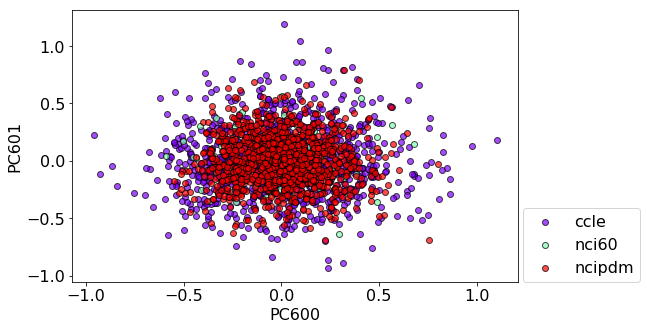

In [10]:
# Compute pca of rna
pca_obj, df_rna_pca, _ = plot_pca(df_rna.iloc[:, 1:], color_vector=meta['source'], components=[600, 601]);
print('Explained variance', pca_obj.explained_variance_ratio_.sum())

In [11]:
print(df_rna.shape)
print(df_rna_pca.shape)

(2276, 943)
(2276, 601)


In [12]:
# Use the pca version of df_rna
# df_rna = pd.concat([df_rna[['Sample']], pd.DataFrame(df_rna_pca)], axis=1)

In [13]:
# Create meta df for each source
ccle_meta = meta[meta['source']=='ccle'].reset_index(drop=True)
nci_meta  = meta[meta['source']=='nci60'].reset_index(drop=True)
pdm_meta  = meta[meta['source']=='ncipdm'].reset_index(drop=True)
print('CCLE meta  {}'.format(ccle_meta.shape))
print('NCI60 meta {}'.format(nci_meta.shape))
print('PDM meta   {}'.format(pdm_meta.shape))

CCLE meta  (1018, 20)
NCI60 meta (60, 20)
PDM meta   (1198, 20)


In [14]:
# Create rna df for each source
ccle_rna, ccle_meta = update_df_and_meta(df_rna, ccle_meta, on='Sample')
nci_rna,  nci_meta  = update_df_and_meta(df_rna, nci_meta,  on='Sample')
pdm_rna,  pdm_meta  = update_df_and_meta(df_rna, pdm_meta,  on='Sample')

In [15]:
# cols_pivot = ['source', 'simplified_csite']
# if set(cols_pivot).issubset(set(meta.columns)):
#     tissue_table = gen_contingency_table(df=meta, cols=cols_pivot, to_plot=True)

In [16]:
# cols_pivot = ['source', 'simplified_ctype']
# if set(cols_pivot).issubset(set(meta.columns)):
#     tissue_table = gen_contingency_table(df=meta, cols=cols_pivot, to_plot=True)

In [17]:
# print(meta['csite'].unique().shape)
# print(meta['simplified_csite'].unique().shape)
# print(meta['ctype'].unique().shape)
# print(meta['simplified_ctype'].unique().shape)

In [18]:
# Concat cell lines data
cells_rna = pd.concat([nci_rna, ccle_rna], axis=0).reset_index(drop=True)
cells_meta = pd.concat([nci_meta, ccle_meta], axis=0).reset_index(drop=True)

## Compute kNN for every pdm sample

In [19]:
dist_metrics_list = [('minkowski', 1), ('minkowski', 2), ('chebyshev', None), ('seuclidean', None)]
label = 'simplified_csite'
ref_col_name = 'Sample'
algorithm = 'brute'
n_neighbors = 10

In [20]:
# Use Euclidean
knn_obj = kNNrnaseq(df_train   = cells_rna,
                    meta_train = cells_meta,
                    df_test    = pdm_rna,
                    meta_test  = pdm_meta,
                    label = label, ref_col_name = ref_col_name,
                    n_neighbors = n_neighbors, algorithm = algorithm,
                    metric = 'minkowski', p = 2)
knn_obj.fit()
knn_obj.neighbors()
print(knn_obj.table_labels['match_total'].sum())

5990


In [21]:
knn_obj.table_samples.to_csv(os.path.join(outdir_samples, 'knn_samples_euclidean.csv'), index=False)
knn_obj.table_labels.to_csv(os.path.join(outdir_samples, 'knn_labels_euclidean.csv'), index=False)
knn_obj.table_distances.to_csv(os.path.join(outdir_samples, 'knn_distances_euclidean.csv'), index=False)

In [22]:
# # Use multiple distance metrics
# for i, m in enumerate(dist_metrics_list):
#     print(i, m)
#     metric = dist_metrics_list[i][0]
#     if metric=='minkowski':
#         p = dist_metrics_list[i][1]
#         metric_params = None
#     else:
#         p = None
#         metric_params = dist_metrics_list[i][1]
        
#     knn_obj = kNNrnaseq(df_train = cells_rna,
#                         meta_train = cells_meta,
#                         df_test = pdm_rna,
#                         meta_test = pdm_meta,
#                         label = label, ref_col_name = ref_col_name,
#                         n_neighbors = n_neighbors, algorithm = algorithm,
#                         metric = metric, p = p, metric_params = metric_params)
#     knn_obj.fit()
#     knn_obj.neighbors()
#     print(knn_obj.table_labels['match_total'].sum())

## Analyze kNN consistency across samples within a given pdm model

### 1. Compute the center location of a pdm model and the neighbors within the model

In [23]:
rna = pdm_rna.copy()
rna = pdm_meta[['Sample', 'core_str', label, 'descr']].merge(rna, on='Sample').rename(
    columns={'core_str': 'model', label: 'label', 'descr': 'passage'})
idx = 4

In [24]:
cols = ['model'] + [c for c in range(pdm_meta['core_str'].value_counts()[0])]
cn0 = pd.DataFrame(index=range(len(pdm_meta['core_str'].unique())), columns=cols)
cn1 = pd.DataFrame(index=range(len(pdm_meta['core_str'].unique())), columns=cols)
cn2 = pd.DataFrame(index=range(len(pdm_meta['core_str'].unique())), columns=cols)

for i, model_name in enumerate(rna['model'].unique()):    
    model_samples = rna[rna['model']==model_name].reset_index(drop=True)
    
    center = model_samples.iloc[:, idx:].mean(axis=0)
    center = center.values[None]
    
    knn = NearestNeighbors(n_neighbors=10, algorithm='brute').fit(model_samples.iloc[:, idx:])
    dist, indices = knn.kneighbors(center, n_neighbors=len(model_samples))
    dist, indices = dist.ravel(), indices.ravel()
    
    cn0.loc[i, 'model'] = model_name
    cn1.loc[i, 'model'] = model_name
    cn2.loc[i, 'model'] = model_name

    cn0.iloc[i, 1:len(indices)+1] = model_samples.loc[indices, 'Sample'].values
    cn1.iloc[i, 1:len(indices)+1] = model_samples.loc[indices, 'passage'].values
    cn2.iloc[i, 1:len(indices)+1] = dist

In [25]:
cn0[:3]

,model,0,1,2,3,4,5,6,7
0,114434~197-R,NCIPDM.114434~197-R~A38WG3J91,NCIPDM.114434~197-R~A38WG5,NCIPDM.114434~197-R~A36YC9,NCIPDM.114434~197-R~A35YC3,NCIPDM.114434~197-R~ORIGINATOR,NCIPDM.114434~197-R~A38WG0JH1,NaN,NaN
1,114551~080-T,NCIPDM.114551~080-T~M667M229C06,NCIPDM.114551~080-T~M667M226C29,NCIPDM.114551~080-T~M667M228C43,NCIPDM.114551~080-T~M676,NCIPDM.114551~080-T~M667M227C30,NaN,NaN,NaN
2,114868~125-R,NCIPDM.114868~125-R~FCWC69,NCIPDM.114868~125-R~FEWC31,NCIPDM.114868~125-R~FEWC21,NCIPDM.114868~125-R~FCWC50,NCIPDM.114868~125-R~ORIGINATOR,NaN,NaN,NaN


In [26]:
cn1[:3]

,model,0,1,2,3,4,5,6,7
0,114434~197-R,"PDX, passage 2","PDX, passage 1","PDX, passage 1","PDX, passage 1",Patient Specimen,"PDX, passage 2",NaN,NaN
1,114551~080-T,"PDX, passage 2","PDX, passage 2","PDX, passage 2","PDX, passage 0","PDX, passage 2",NaN,NaN,NaN
2,114868~125-R,"PDX, passage 1","PDX, passage 1","PDX, passage 1","PDX, passage 1",Patient Specimen,NaN,NaN,NaN


In [27]:
cn2[:3]

,model,0,1,2,3,4,5,6,7
0,114434~197-R,7.15373,7.37169,8.49,9.52218,12.4467,14.6377,NaN,NaN
1,114551~080-T,5.57381,5.99112,6.59205,7.02048,10.253,NaN,NaN,NaN
2,114868~125-R,7.33184,7.44564,8.46073,10.0939,23.1336,NaN,NaN,NaN


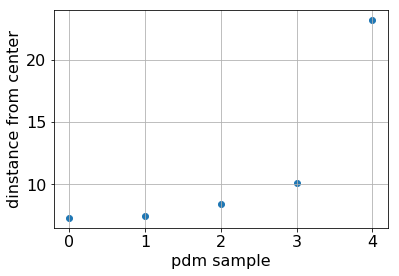

In [28]:
ii = cn2['model']=='114868~125-R'
y = cn2.loc[ii].iloc[:, 1:].dropna(axis=1).values.ravel()
plt.scatter(range(len(y)), y);
plt.xlabel('pdm sample')
plt.ylabel('dinstance from center')
plt.grid()

#### Outlier detection

In [29]:
# from sklearn.ensemble import IsolationForest
# m = IsolationForest(n_estimators=200, max_samples='auto', contamination=0.05,
#                     max_features=1.0, bootstrap=False, n_jobs=-1, random_state=None, verbose=0)

# m.fit(X=rna.iloc[:, 4:].values);
# preds = m.predict(rna.iloc[:, 4:].values)

# tmp = rna[['Sample', 'model', 'label', 'passage']].copy()
# tmp.insert(loc=1, column='outlr', value=preds)

# tmp['outlr'].value_counts()
# tmp.sort_values('outlr')

### 2. Get the model prevalent cell line neighbors for every pdm model

In [30]:
table_samples = knn_obj.table_samples.copy()
table_distances = knn_obj.table_distances.copy()

table_samples = pdm_meta[['Sample', 'core_str', label, 'descr']].merge(table_samples, on='Sample').rename(
    columns={'core_str': 'model', label: 'label', 'descr': 'passage'})
table_distances = pdm_meta[['Sample', 'core_str', label, 'descr']].merge(table_distances, on='Sample').rename(
    columns={'core_str': 'model', label: 'label', 'descr': 'passage'})

Test a specific sample

In [31]:
# model_name = table_samples['model'].unique()[1]

# samples = table_samples[table_samples['model']==model_name]
# samples = samples[[c for c in samples.columns if 'nbr' in c]]

# dist = table_distances[table_distances['model']==model_name]
# dist = dist[[c for c in dist.columns if 'nbr' in c]]

# print(model_name)

In [32]:
# samples

In [33]:
# dist

In [34]:
# tmp = pd.DataFrame({'Sample': samples.values.ravel(), 'dist': dist.values.ravel()})
# tmp['count'] = 1
# tmp = tmp.groupby(['Sample']).agg({'dist': 'sum', 'count': 'sum'}).reset_index()
# tmp = tmp.sort_values(['count', 'dist'], ascending=[False, True]).reset_index(drop=True)
# tmp[:10]

In [35]:
mn0 = pd.DataFrame(index=range(len(table_samples['model'].unique())),
                  columns=[['model'] + ['nbr {}'.format(c) for c in range(10)]])

mn1 = pd.DataFrame(index=range(len(table_samples['model'].unique())),
                  columns=[['model'] + ['nbr {}'.format(c) for c in range(10)]])

for i, model_name in enumerate(table_samples['model'].unique()):
    mn0.loc[i, 'model'] = model_name
    mn1.loc[i, 'model'] = model_name
    
    samples = table_samples[table_samples['model']==model_name]
    samples = samples[[c for c in samples.columns if 'nbr' in c]]

    dist = table_distances[table_distances['model']==model_name]
    dist = dist[[c for c in dist.columns if 'nbr' in c]]
    
    tmp = pd.DataFrame({'Sample': samples.values.ravel(), 'dist': dist.values.ravel()})
    tmp['count'] = 1
    tmp = tmp.groupby(['Sample']).agg({'dist': 'sum', 'count': 'sum'}).reset_index()
    tmp = tmp.sort_values(['count', 'dist'], ascending=[False, True]).reset_index(drop=True)
    
    mn0.iloc[i, 1:] = tmp['Sample'][:10].values
    mn1.iloc[i, 1:] = tmp['count'][:10].values

In [36]:
mn0[:3]

,model,nbr 0,nbr 1,nbr 2,nbr 3,nbr 4,nbr 5,nbr 6,nbr 7,nbr 8,nbr 9
0,114434~197-R,CCLE.LN215,CCLE.HS729,CCLE.YKG1,CCLE.LN235,CCLE.SNB75,CCLE.GMS10,NCI60.SNB-75,CCLE.HEKTE,CCLE.KALS1,CCLE.SKLMS1
1,114551~080-T,CCLE.ISHIKAWAHERAKLIO02ER,CCLE.LOVO,CCLE.LNCAPCLONEFGC,CCLE.LS411N,CCLE.JHUEM1,CCLE.LS180,CCLE.SNU175,CCLE.L33,CCLE.COLO320,CCLE.VCAP
2,114868~125-R,CCLE.SF767,CCLE.BICR18,CCLE.TE9,CCLE.SNU503,CCLE.KYSE510,CCLE.HARA,CCLE.TE11,CCLE.FADU,CCLE.TE15,CCLE.HCC2814


In [37]:
mn1[:3]

,model,nbr 0,nbr 1,nbr 2,nbr 3,nbr 4,nbr 5,nbr 6,nbr 7,nbr 8,nbr 9
0,114434~197-R,6,6,6,6,5,4,4,3,3,3
1,114551~080-T,5,5,5,5,5,5,5,5,4,3
2,114868~125-R,4,4,4,4,4,4,3,3,3,2


In [38]:
mn0.to_csv(os.path.join(outdir_models_count, 'knn_samples.csv'), index=False)
mn1.to_csv(os.path.join(outdir_models_count, 'knn_count.csv'), index=False)

### 3. Get summary table for models

In [39]:
table_samples   = knn_obj.table_samples.copy()
table_labels    = knn_obj.table_labels.copy()
table_distances = knn_obj.table_distances.copy()

In [40]:
table_samples = pdm_meta[['Sample', 'core_str', label, 'descr']].merge(table_samples, on='Sample').rename(
    columns={'core_str': 'model', label: 'label', 'descr': 'passage'})
table_labels = pdm_meta[['Sample', 'core_str', label, 'descr']].merge(table_labels, on='Sample').rename(
    columns={'core_str': 'model', label: 'label', 'descr': 'passage'})
table_distances = pdm_meta[['Sample', 'core_str', label, 'descr']].merge(table_distances, on='Sample').rename(
    columns={'core_str': 'model', label: 'label', 'descr': 'passage'})

In [41]:
table_labels    = table_labels.sort_values(by=['match_total', 'model'], ascending=False)
table_samples   = table_samples.reindex(table_labels.index)
table_distances = table_distances.reindex(table_labels.index)

In [42]:
table_labels.reset_index(drop=True, inplace=True)
table_samples.reset_index(drop=True, inplace=True)
table_distances.reset_index(drop=True, inplace=True)

In [43]:
table_labels[:2]

,Sample,model,label,passage,label,match_total,nbr 0,nbr 1,nbr 2,nbr 3,nbr 4,nbr 5,nbr 6,nbr 7,nbr 8,nbr 9
0,NCIPDM.LG0703~F948~M2M110M230M345M428,LG0703~F948,lung,"PDX, passage 4",lung,10,lung,lung,lung,lung,lung,lung,lung,lung,lung,lung
1,NCIPDM.LG0703~F948~M3M218M339,LG0703~F948,lung,"PDX, passage 2",lung,10,lung,lung,lung,lung,lung,lung,lung,lung,lung,lung


In [44]:
table_samples[:2]

,Sample,model,label,passage,nbr 0,nbr 1,nbr 2,nbr 3,nbr 4,nbr 5,nbr 6,nbr 7,nbr 8,nbr 9
0,NCIPDM.LG0703~F948~M2M110M230M345M428,LG0703~F948,lung,"PDX, passage 4",CCLE.NCIH3255,CCLE.HCC2935,CCLE.NCIH2291,CCLE.SW900,CCLE.HCC4006,CCLE.RERFLCAD1,CCLE.HCC1171,CCLE.NCIH1648,CCLE.NCIH1781,CCLE.LCLC97TM1
1,NCIPDM.LG0703~F948~M3M218M339,LG0703~F948,lung,"PDX, passage 2",CCLE.HCC2935,CCLE.NCIH3255,CCLE.NCIH2291,CCLE.SW900,CCLE.HCC4006,CCLE.HCC1171,CCLE.RERFLCAD1,CCLE.NCIH1648,CCLE.NCIH596,CCLE.NCIH441


In [45]:
table_distances[:2]

,Sample,model,label,passage,nbr 0,nbr 1,nbr 2,nbr 3,nbr 4,nbr 5,nbr 6,nbr 7,nbr 8,nbr 9
0,NCIPDM.LG0703~F948~M2M110M230M345M428,LG0703~F948,lung,"PDX, passage 4",31.4985,31.5983,33.2252,33.2468,34.104,34.3477,34.5218,34.8797,34.9173,34.9334
1,NCIPDM.LG0703~F948~M3M218M339,LG0703~F948,lung,"PDX, passage 2",34.6532,35.0854,36.9821,37.4082,37.6328,37.7998,38.0803,38.2994,38.3375,38.5006


In [46]:
# i, model_name = 2, table_samples['model'].unique()[2]
# tmp = table_labels[table_labels['model']==model_name]

In [47]:
ss = pd.DataFrame(index=range(len(table_samples['model'].unique())),
                  columns=['model', 'samples', 'match', 'nunique', 'dist'])

for i, model_name in enumerate(table_samples['model'].unique()):
    ss.loc[i, 'model'] = model_name
    
    tmp = table_labels[table_labels['model']==model_name]
    ss.loc[i, 'samples'] = len(tmp)
    ss.loc[i, 'match'] = tmp['match_total'].sum()/len(tmp)
    
    tmp = table_samples[table_samples['model']==model_name]
    tmp = tmp[[c for c in tmp.columns if 'nbr' in c]]
    ss.loc[i, 'nunique'] = len(np.unique(tmp.values.ravel()))
    
    tmp = table_distances[table_distances['model']==model_name]
    tmp = tmp[[c for c in tmp.columns if 'nbr' in c]]
    ss.loc[i, 'dist'] = np.sum(tmp.values.ravel())/(10*len(tmp))

In [48]:
ss.sort_values(['match', 'nunique'], ascending=[False, True]).reset_index(drop=True)[:10]

,model,samples,match,nunique,dist
0,638129~119-R,5,10,13,27.7671
1,199195~117-R,4,10,13,27.918
2,128128~338-R,6,10,13,29.9136
3,515677~202-R,6,10,19,35.349
4,714841~288-R,6,9.83333,19,30.3973
5,519858~162-T,6,9.83333,21,28.331
6,186277~243-T,4,9.75,13,25.3955
7,158597~082-R,4,9.75,14,27.1742
8,CN0330~F216,6,9.66667,19,27.4665
9,563396~261-R,6,9.66667,20,31.8129


In [51]:
tmp = table_samples.groupby(['model'], as_index=False).agg({'label': 'unique',
                                                      'nbr 0': 'unique', 'nbr 1': 'unique', 'nbr 2': 'unique',
                                                      'nbr 3': 'unique', 'nbr 4': 'unique', 'nbr 5': 'unique',
                                                      'nbr 6': 'unique', 'nbr 7': 'unique', 'nbr 8': 'unique',
                                                      'nbr 9': 'unique',
                                                     })

In [52]:
tmp['label'] = tmp['label'].map(lambda x: x[0])
tmp

,model,label,nbr 0,nbr 1,nbr 2,nbr 3,nbr 4,nbr 5,nbr 6,nbr 7,nbr 8,nbr 9
0,114434~197-R,musculoskeletal,"[CCLE.LN215, CCLE.HS729, CCLE.HEKTE]","[CCLE.HS729, CCLE.LN215, CCLE.YKG1]","[CCLE.YKG1, CCLE.LN235, NCI60.SF-539]","[CCLE.LN235, CCLE.YKG1, CCLE.HS729, CCLE.SNB75]","[CCLE.SNB75, CCLE.SKLMS1, CCLE.GMS10]","[CCLE.GI1, CCLE.SW1783, CCLE.LN235, NCI60.SNB-...","[CCLE.SKLMS1, CCLE.GMS10, CCLE.YKG1, CCLE.OELE...","[NCI60.SNB-75, CCLE.KALS1, CCLE.OC314, CCLE.GM...","[CCLE.KALS1, CCLE.CAL78, CCLE.HOP62, CCLE.HEKT...","[NCI60.SF-539, CCLE.SF126, CCLE.SLR20, CCLE.GI..."
1,114551~080-T,head & neck,"[CCLE.LNCAPCLONEFGC, CCLE.LOVO, CCLE.ISHIKAWAH...","[CCLE.LOVO, CCLE.LNCAPCLONEFGC]","[CCLE.JHUEM1, CCLE.LS411N, CCLE.LNCAPCLONEFGC,...","[CCLE.ISHIKAWAHERAKLIO02ER, CCLE.JHUEM1, CCLE....","[CCLE.LS411N, CCLE.SNU175, CCLE.JHUEM1]","[CCLE.SNU175, CCLE.JHUEM1, CCLE.LS180, CCLE.L33]","[CCLE.LS180, CCLE.L33, CCLE.SNU175, CCLE.COLO320]","[CCLE.L33, CCLE.LS180, CCLE.SNU175]","[CCLE.CORL105, CCLE.VCAP, CCLE.COLO320, CCLE.S...","[CCLE.CL34, CCLE.COLO320, CCLE.VCAP, CCLE.CADO..."
2,114868~125-R,head & neck,"[CCLE.SF767, CCLE.RERFLCMS]","[CCLE.BICR18, CCLE.TE9, CCLE.OELE]","[CCLE.TE9, CCLE.BICR18, CCLE.SNB75]","[CCLE.TE11, CCLE.KYSE510, CCLE.SNU46]","[CCLE.SNU503, CCLE.NCIH1975]","[CCLE.HARA, CCLE.FADU, CCLE.JHUEM3]","[CCLE.TE15, CCLE.FADU, CCLE.HCC2814, CCLE.NCIH...","[CCLE.KYSE510, CCLE.PECAPJ34CLONEC12, CCLE.HCC...","[CCLE.FADU, CCLE.KYSE510, CCLE.TE11, CCLE.TE15...","[CCLE.A253, CCLE.T3M4, CCLE.HCC95, CCLE.RERFLC..."
3,116653~092-T,gynecologic,"[CCLE.NCIH2085, CCLE.HCC1143, CCLE.NCIH1650, C...","[CCLE.HEKTE, CCLE.HCC38, CCLE.NCIH1650, CCLE.H...","[CCLE.OC314, NCI60.EKVX, CCLE.NCIH1650, CCLE.N...","[CCLE.DU145, CCLE.HCC1171, CCLE.HCC1143, NCI60...","[CCLE.SNU840, CCLE.NCIH1650, CCLE.HCC1171, NCI...","[CCLE.SNU8, CCLE.NCIH1975, CCLE.HEKTE, NCI60.E...","[CCLE.NCIH1650, CCLE.SNU840, CCLE.DU145, CCLE....","[CCLE.RERFLCAI, CCLE.NCIH2085, CCLE.HCC1143, C...","[CCLE.HCC1171, CCLE.HCC1954, CCLE.NCIH1975, CC...","[CCLE.NCIH1975, CCLE.EFO27, CCLE.OC314, CCLE.H..."
4,116653~108-T,gynecologic,"[CCLE.LOVO, CCLE.HEKTE, CCLE.HCC38, CCLE.HCC19...","[NCI60.DU-145, CCLE.NCIH1650, CCLE.MDAMB468, C...","[NCI60.MDA-MB-468, CCLE.DU145, CCLE.NCIH1568, ...","[CCLE.HeLa, CCLE.647V, CCLE.HCC1937, CCLE.DU14...","[CCLE.HEKTE, CCLE.RERFLCAI, CCLE.HCC1143, CCLE...","[CCLE.OC314, CCLE.HeLa, NCI60.EKVX, CCLE.NCIH2...","[CCLE.JHUEM1, CCLE.OC314, CCLE.MDAMB468, CCLE....","[CCLE.SF767, CCLE.NCIH1975, CCLE.HCC1171, CCLE...","[CCLE.RERFLCAI, CCLE.NCIH2085, CCLE.HCC1954, N...","[CCLE.JHOS2, CCLE.CAL851, CCLE.HCC70, CCLE.647..."
5,117519~064-T,prostate,"[CCLE.LNCAPCLONEFGC, CCLE.VCAP, NCI60.HCT-15]","[CCLE.VCAP, CCLE.MDAPCA2B, CCLE.LNCAPCLONEFGC,...","[CCLE.MDAPCA2B, CCLE.VCAP, CCLE.22RV1]","[CCLE.22RV1, CCLE.MDAMB361, CCLE.MDAPCA2B, CCL...","[CCLE.MDAMB361, CCLE.22RV1, NCI60.PC-3, CCLE.P...","[NCI60.PC-3, CCLE.SNUC2A, CCLE.OC314, NCI60.DU...","[CCLE.SNUC2A, CCLE.SNUC4, CCLE.LOVO, NCI60.LOX...","[CCLE.LS180, NCI60.PC-3, CCLE.OC314, NCI60.NCI...","[CCLE.NCIH1048, CCLE.LS180, CCLE.639V, CCLE.LS...","[CCLE.NCIH1373, CCLE.NCIH1568, NCI60.HCT-116, ..."
6,126254~015-R,musculoskeletal,"[CCLE.HS888T, CCLE.WM793, CCLE.HS729, CCLE.HS683]","[CCLE.RPMI7951, CCLE.HS888T, CCLE.CH157MN, CCL...","[CCLE.YH13, CCLE.RPMI7951, CCLE.HOP62, CCLE.HS...","[CCLE.HS751T, CCLE.HS683, CCLE.HS229T, CCLE.SW...","[CCLE.TCCSUP, CCLE.HS751T, CCLE.SF126, CCLE.TI...","[CCLE.HS739T, CCLE.HS343T, CCLE.RERFLCAI, CCLE...","[CCLE.TO175T, CCLE.HS840T, CCLE.SW1088, CCLE.C...","[CCLE.T173, CCLE.YH13, CCLE.OELE, CCLE.GAMG, C...","[CCLE.NHA, CCLE.TIG3TD, CCLE.U178, CCLE.HS840T]","[CCLE.HS600T, CCLE.HS729, CCLE.SNU423, CCLE.SF..."
7,128128~338-R,skin,"[CCLE.HS936T, CCLE.SKMEL30, CCLE.MELHO]","[CCLE.MELHO, CCLE.HS936T, NCI60.UACC-257, CCLE...","[CCLE.SKMEL5, CCLE.MELHO, CCLE.HS936T, CCLE.UA...","[CCLE.SKMEL30, CCLE.IGR37, NCI60.SK-MEL-5, NCI...","[NCI60.UACC-257, CCLE.SKMEL5, CCLE.HS936T, CCL...","[CCLE.IGR37, NCI60.M14, CCLE.UACC

## Compute kNN for every pdm sample - averaged across multiple distance metrics

#### Long running time!

In [23]:
knn_results = knn_for_single_rna_summary(cells_rna, cells_meta,
                                         pdm_rna, pdm_meta,
                                         label='simplified_csite',
                                         n_neighbors = n_neighbors, algorithm = algorithm)
knn_samples, knn_labels, knn_distances = knn_results
print(knn_labels['match_total'].sum())

1/1198: NCIPDM.114434~197-R~A35YC3
101/1198: NCIPDM.172845~121-B~M770J03J74
201/1198: NCIPDM.227169~078-T~JN4K38
301/1198: NCIPDM.286954~287-R~Z86
401/1198: NCIPDM.381576~328-R~J30M844
501/1198: NCIPDM.471365~239-R~FB5P21
601/1198: NCIPDM.592915~224-R~A96AZ4IF8
701/1198: NCIPDM.695221~133-T~VV9M19
801/1198: NCIPDM.765638~272-R~AG2I09
901/1198: NCIPDM.889142~216-R~T53TC4
1001/1198: NCIPDM.969956~357-R~CNNUN3
1101/1198: NCIPDM.LG0476~F007~M25M102M223M334
5788


In [24]:
knn_samples.to_csv(os.path.join(outdir_samples, 'knn_samples_averaged.csv'), index=False)
knn_labels.to_csv(os.path.join(outdir_samples, 'knn_labels_averaged.csv'), index=False)
knn_distances.to_csv(os.path.join(outdir_samples, 'knn_distances_averaged.csv'), index=False)

## Compute kNN for every pdm model

https://stackoverflow.com/questions/77936/whats-the-best-way-to-calculate-a-3d-or-n-d-centroid

In [25]:
# For every pdm model compute a single rna expression
m_rna, m_meta, pdm_model_names = gen_single_rna_for_each_pdm_model(pdm_rna, pdm_meta)

Total number of unique pdm models: 234
m_meta.shape (234, 5)
m_rna.shape (234, 943)


In [26]:
label = 'simplified_csite'
ref_col_name = 'Sample'
algorithm = 'brute'
n_neighbors = 10

In [27]:
# Use Euclidean
knn_obj = kNNrnaseq(df_train   = cells_rna,
                    meta_train = cells_meta,
                    df_test    = m_rna,
                    meta_test  = m_meta,
                    label = label, ref_col_name = ref_col_name,
                    n_neighbors = n_neighbors, algorithm = algorithm,
                    metric = 'minkowski', p = 2)
knn_obj.fit()
knn_obj.neighbors()
print(knn_obj.table_labels['match_total'].sum())

1196


In [28]:
# Rename back 'Sample' into 'Model'
m_meta.rename(columns={'Sample': 'Model'}, inplace=True)
m_rna.rename(columns={'Sample': 'Model'}, inplace=True)

table_labels = knn_obj.table_labels.copy()
table_labels.rename(columns={'Sample': 'Model'}, inplace=True)
table_samples = knn_obj.table_samples.copy()
table_samples.rename(columns={'Sample': 'Model'}, inplace=True)
table_distances = knn_obj.table_distances.copy()
table_distances.rename(columns={'Sample': 'Model'}, inplace=True)

# table_samples = table_samples.reindex(table_labels.index)
# table_labels['match_total'].value_counts()

In [29]:
table_samples.to_csv(os.path.join(outdir_models, 'knn_samples.csv'), index=False)
table_labels.to_csv(os.path.join(outdir_models, 'knn_labels.csv'), index=False)
table_distances.to_csv(os.path.join(outdir_models, 'knn_distances.csv'), index=False)

## Compute kNN for every pdm model - averaged across multiple distance metrics

#### Iter over pdm models and compute kNN for using difrenet distnaces metrics

In [30]:
# For every pdm model compute a single rna expression
m_rna, m_meta = gen_single_rna_for_each_pdm_model(pdm_rna, pdm_meta)

Total number of unique pdm models: 234
m_meta.shape (234, 5)
m_rna.shape (234, 943)


In [31]:
knn_results = knn_for_single_rna_summary(cells_rna, cells_meta,
                                         m_rna, m_meta,
                                         label='simplified_csite',
                                         n_neighbors = n_neighbors, algorithm = algorithm)
knn_samples, knn_labels, knn_distances = knn_results
print(knn_labels['match_total'].sum())

1/234: 114434~197-R
101/234: 466732~252-T
201/234: 999852~294-R
1166


In [32]:
# Rename back 'Sample' into 'Model'
m_meta.rename(columns={'Sample': 'Model'}, inplace=True)
m_rna.rename(columns={'Sample': 'Model'}, inplace=True)

table_labels = knn_obj.table_labels.copy()
table_labels.rename(columns={'Sample': 'Model'}, inplace=True)
table_samples = knn_obj.table_samples.copy()
table_samples.rename(columns={'Sample': 'Model'}, inplace=True)
table_distances = knn_obj.table_distances.copy()
table_distances.rename(columns={'Sample': 'Model'}, inplace=True)

# table_samples = table_samples.reindex(table_labels.index)
# table_labels['match_total'].value_counts()

In [33]:
table_samples.to_csv(os.path.join(outdir_models, 'knn_samples_averaged.csv'), index=False)
table_labels.to_csv(os.path.join(outdir_models, 'knn_labels_averaged.csv'), index=False)
table_distances.to_csv(os.path.join(outdir_models, 'knn_distances_averaged.csv'), index=False)

#### Example:  compute neighbors for a single model

In [34]:
# For every pdm model compute a single rna expression
m_rna, m_meta = gen_single_rna_for_each_pdm_model(pdm_rna, pdm_meta)

Total number of unique pdm models: 234
m_meta.shape (234, 5)
m_rna.shape (234, 943)


In [35]:
single_rna = m_rna.iloc[0, :].to_frame().T
single_meta = m_meta.iloc[0, :].to_frame().T

In [36]:
# label = 'simplified_ctype'
label = 'simplified_csite'
ref_col_name = 'Sample'
dist_metrics_list = [('minkowski', 1), ('minkowski', 2), ('chebyshev', None), ('seuclidean', None)]
algorithm = 'brute'
n_neighbors = 5
knn_results = knn_for_single_rna(cells_rna, cells_meta,
                                 single_rna, single_meta,
                                 label, ref_col_name, 
                                 dist_metrics_list,
                                 n_neighbors, algorithm)
table_samples, table_distances, table_labels = knn_results

In [37]:
c0 = pd.DataFrame(table_samples.iloc[:, 1:].values.ravel()).rename(columns={0: 'Sample'})
c1 = pd.DataFrame(table_labels.iloc[:, 3:].values.ravel()).rename(columns={0: label})

for r in range(table_distances.shape[0]):
    table_distances.iloc[r, 1:] = table_distances.iloc[r, 1:] / table_distances.iloc[r, 1:].sum()
c2 = pd.DataFrame(table_distances.iloc[:, 1:].values.ravel()).rename(columns={0: 'dist'})
tt = pd.concat([c0, c1, c2], axis=1)
tt['count'] = 1

In [38]:
tt = tt.groupby(['Sample']).agg({label: 'unique', 'count': sum, 'dist': 'unique'}).reset_index()
tt['dist'] = tt['dist'].map(lambda x: np.mean(x))
tt[label] = tt[label].map(lambda x: x[0] if len(x)==1 else x)
tt = tt.sort_values(by=['count', 'dist'], ascending=[False, True]).reset_index(drop=True)

In [39]:
tt

,Sample,simplified_csite,count,dist
0,CCLE.LN215,neurologic,3,0.197165
1,CCLE.LN235,neurologic,3,0.198414
2,CCLE.YKG1,neurologic,3,0.199204
3,CCLE.HS729,musculoskeletal,3,0.200074
4,CCLE.SNB75,neurologic,2,0.204123
5,CCLE.CAL78,musculoskeletal,1,0.191689
6,CCLE.KNS60,neurologic,1,0.201620
7,NCI60.SF-295,neurologic,1,0.202077
8,CCLE.OELE,gynecologic,1,0.203251
9,CCLE.HLFA,lung,1,0.204025


## Find Yvonne's models in our predictions

In [40]:
tmp = pd.read_csv('yvonne_models.txt', sep='\t', header=None).rename(columns={0: 'Sample'})
models = tmp['Sample'].values

In [41]:
models

array(['172845-121-T', '235635-245-T', '245127-232-R', '252836-082-R',
       '283339-068-R', '327498-153-R', '594176-295-R', '743489-274-T',
       '767577-098-T', '779769-127-R', '845751-090-R', '997537-175-T',
       '997726-040-R', 'BL0293-F563', 'BL0382-F1232', 'BL0479-F1894',
       'CN0375-F725', 'CN0446-F447', 'LG0481-F231', 'LG0520-F434',
       'LG0556-F006', 'LG0567-F671', 'LG0703-F948', 'LG1011-PE1607',
       'LG1049-F1704', 'LG1189-F1952'], dtype=object)

In [45]:
knn_samples = pd.read_csv(os.path.join(outdir_samples, 'knn_samples_euclidean.csv'))
knn_distances = pd.read_csv(os.path.join(outdir_samples, 'knn_distances_euclidean.csv'))
knn_labels = pd.read_csv(os.path.join(outdir_samples, 'knn_labels_euclidean.csv'))

In [46]:
def func(x, models):
    xx = x.split('.')[-1].replace('~', '-')
    val = np.bool(sum([True if m in xx else False for m in models]))
    return val

In [47]:
idx = knn_samples['Sample'].map(lambda x: func(x, models) )

In [48]:
knn_samples = knn_samples[idx].reset_index(drop=True)
knn_distances = knn_distances[idx].reset_index(drop=True)
knn_labels = knn_labels[idx].reset_index(drop=True)

In [49]:
knn_samples[:10]

,Sample,nbr 0,nbr 1,nbr 2,nbr 3,nbr 4,nbr 5,nbr 6,nbr 7,nbr 8,nbr 9
0,NCIPDM.172845~121-T~M776,CCLE.SNUC4,CCLE.LS180,CCLE.NCIH684,CCLE.LOVO,CCLE.CL34,CCLE.JHOM2B,CCLE.SNU61,CCLE.SW948,CCLE.T84,CCLE.LS513
1,NCIPDM.172845~121-T~M776M1151,CCLE.SNUC4,CCLE.LS180,CCLE.LOVO,CCLE.JHOM2B,CCLE.CL34,CCLE.NCIH684,CCLE.SW948,CCLE.T84,CCLE.SNU61,CCLE.LS411N
2,NCIPDM.172845~121-T~M776M1152J66,CCLE.SNUC4,CCLE.JHOM2B,CCLE.LS180,CCLE.SW948,CCLE.LOVO,CCLE.CL34,CCLE.NCIH684,CCLE.LS411N,CCLE.GP2D,CCLE.SNUC5
3,NCIPDM.172845~121-T~M776M1153J58,CCLE.SNUC4,CCLE.JHOM2B,CCLE.LS180,CCLE.LOVO,CCLE.SW948,CCLE.CL34,CCLE.LS411N,CCLE.GP2D,CCLE.NCIH684,CCLE.SNUC5
4,NCIPDM.172845~121-T~M776M1154J15,CCLE.SNUC4,CCLE.LOVO,CCLE.JHOM2B,CCLE.LS180,CCLE.SW948,CCLE.CL34,CCLE.NCIH684,CCLE.SNU61,CCLE.T84,CCLE.SNUC5
5,NCIPDM.172845~121-T~M776M1155J93,CCLE.SNUC4,CCLE.LS180,CCLE.LOVO,CCLE.JHOM2B,CCLE.SNU61,CCLE.CL34,CCLE.NCIH684,CCLE.SW948,CCLE.T84,CCLE.LS513
6,NCIPDM.235635~245-T~D33,NCI60.NCI-H522,NCI60.HT29,NCI60.HCT-15,NCI60.ACHN,NCI60.HS-578T,NCI60.MCF7,CCLE.SW480,CCLE.NCIH1693,NCI60.HCC-2998,NCI60.MDA-MB-468
7,NCIPDM.235635~245-T~D33M940_RG-03A,NCI60.HT29,NCI60.HCT-15,NCI60.KM12,NCI60.NCI-H522,CCLE.OVMANA,CCLE.KMS-18-2,NCI60.MCF7,CCLE.OE21,CCLE.BICR6,NCI60.HCC-2998
8,NCIPDM.235635~245-T~D33M941,CCLE.SNUC2A,CCLE.MDAMB361,CCLE.MFE319,CCLE.HCC1937,CCLE.SiHa,CCLE.EFO27,CCLE.NCIH1048,CCLE.MDAMB468,CCLE.NCIH1650,CCLE.LN18
9,NCIPDM.235635~245-T~D33M941Y63,CCLE.SNUC2A,CCLE.NCIH1048,CCLE.CAL51,CCLE.SiHa,CCLE.EFO27,CCLE.MFE319,CCLE.HCC1937,CCLE.HCC38,CCLE.NCIH1650,CCLE.DU145


In [50]:
# knn_samples.to_csv('subset_knn_samples.csv', index=False)
# knn_distances.to_csv('subset_knn_distances.csv', index=False)
# knn_labels.to_csv('subset_knn_labels.csv', index=False)